## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import os

In [2]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Deff2',
          'Mean Mean_Intensity', 'Std Mean_Intensity',
          'X', 'Y', 'Mean X', 'Mean Y', 'Std X', 'Std Y']
calcs = [3]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
                # os.remove(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                #fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
                #print(num)
                print(filename)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('skip filename: {}'.format(filename))

features_10k_PEG_3mM_XY01.csv
features_10k_PEG_3mM_XY02.csv
features_10k_PEG_3mM_XY03.csv
features_10k_PEG_3mM_XY04.csv
features_10k_PEG_3mM_XY05.csv
features_10k_PEG_3mM_XY06.csv
features_10k_PEG_3mM_XY07.csv
features_10k_PEG_3mM_XY08.csv
features_10k_PEG_3mM_XY09.csv
features_10k_PEG_3mM_XY10.csv
features_5k_PEG_3mM_XY01.csv
features_5k_PEG_3mM_XY02.csv
features_5k_PEG_3mM_XY03.csv
features_5k_PEG_3mM_XY04.csv
features_5k_PEG_3mM_XY05.csv
features_5k_PEG_3mM_XY06.csv
features_5k_PEG_3mM_XY07.csv
features_5k_PEG_3mM_XY08.csv
features_5k_PEG_3mM_XY09.csv
features_5k_PEG_3mM_XY10.csv
features_1k_PEG_3mM_XY01.csv
features_1k_PEG_3mM_XY02.csv
features_1k_PEG_3mM_XY03.csv
features_1k_PEG_3mM_XY04.csv
features_1k_PEG_3mM_XY05.csv
features_1k_PEG_3mM_XY06.csv
features_1k_PEG_3mM_XY07.csv
features_1k_PEG_3mM_XY08.csv
features_1k_PEG_3mM_XY09.csv
features_1k_PEG_3mM_XY10.csv
features_PS_COOH_3mM_XY01.csv
features_PS_COOH_3mM_XY02.csv
features_PS_COOH_3mM_XY03.csv
features_PS_COOH_3mM_XY04.csv


In [3]:
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
featofvar = 'Particle Type'
#ncomp = 15

# X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
# y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

# for run in range(1):
#     clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
#                         alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
#                         early_stopping=True, validation_fraction=0.1)

#     clf.fit(X_train, y_train)
    
#     print('Training Results')
#     y_true1, y_pred1 = y_train, clf.predict(X_train)
#     print(classification_report(y_true1, y_pred1, digits=4))
    
#     print('Test Results')
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred, digits=4))

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
ncomp = 15
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.17528928160565335
1 component: 0.28295394936045115
2 component: 0.3804427572993729
3 component: 0.4484262516296369
4 component: 0.5074591832326065
5 component: 0.5549000525360149
6 component: 0.5956012253244607
7 component: 0.6354373750221859
8 component: 0.6688485146175285
9 component: 0.6978565954840443
10 component: 0.7253355855626502
11 component: 0.7502503982427549
12 component: 0.7721838888489826
13 component: 0.791948907487441
14 component: 0.8103445301607619


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [8]:
kmostat = pca.kmo(pca_train.scaled)

0.831113796361


In [9]:
pca_train.final.head()

,index,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,5,6,7,8,9,10,11,12,13,14
0,2,2.0,2.183635,0.009453,3.502812,0.877144,0.180995,0.275045,2.682485,0.627211,...,-0.564659,1.139744,-0.824976,0.339950,-1.073598,-1.197185,0.406631,0.584250,0.749816,1.114531
1,3,3.0,0.768083,2.787053,2.129733,0.655473,0.324359,0.139416,1.450872,0.310759,...,-2.231060,-0.368735,2.218697,0.307713,-0.030960,0.369210,0.580075,0.261626,1.947445,1.079361
2,4,4.0,1.088506,0.197738,2.609634,0.011945,0.896073,0.001503,1.161800,0.139267,...,-2.261615,-0.211075,-1.780752,-1.341017,-0.701968,0.521719,-0.893010,0.746466,0.863634,0.942345
3,7,7.0,0.097574,3.315190,2.065681,0.541447,0.390110,0.101196,1.496095,0.331593,...,0.803999,0.162234,0.993487,0.924351,0.969101,-1.254788,-0.616382,1.054484,1.694227,0.705614
4,8,8.0,1.053644,0.298079,3.321611,0.868022,0.188069,0.265948,1.646770,0.392751,...,-2.588278,-0.770282,2.403636,0.040768,0.593309,-1.809283,-0.620774,1.709025,0.125676,0.356957


In [10]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [11]:
import numpy as np
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='10k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='1k_PEG'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)

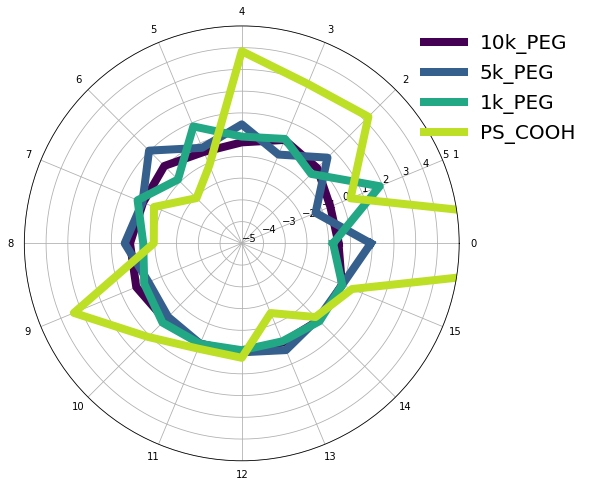

In [12]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-5, 5, 11))

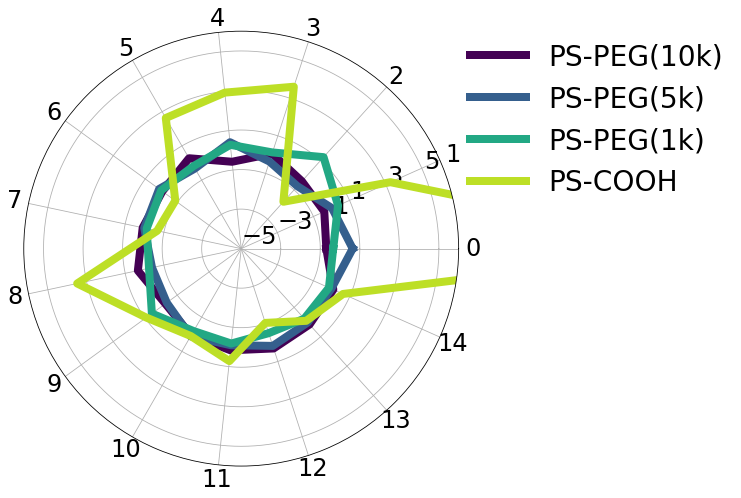

In [15]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
labels2 = ['PS-PEG(10k)', 'PS-PEG(5k)', 'PS-PEG(1k)', 'PS-COOH']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-5, 5, 6), dpi=1200, labelsize=24,
             filename='pics/mw3_pcaavg.png')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

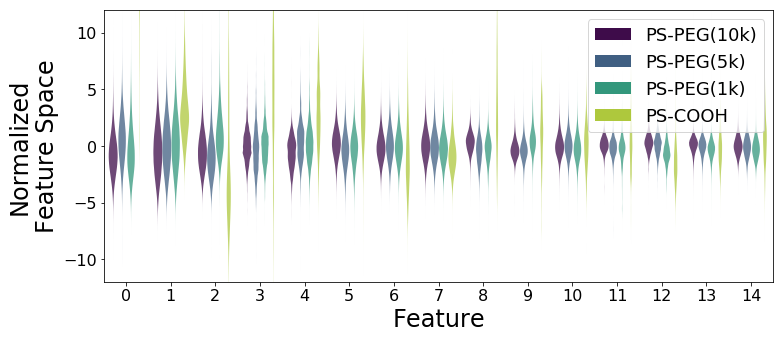

In [17]:
feats = feature_violin(pca_train.final, label='Particle Type', lvals=labels, labels=labels2, fsubset=ncomp, yrange=[-12, 12],
                       legendfontsize=21, labelsize=24, fname='./pics/mw3_pcadist.png')

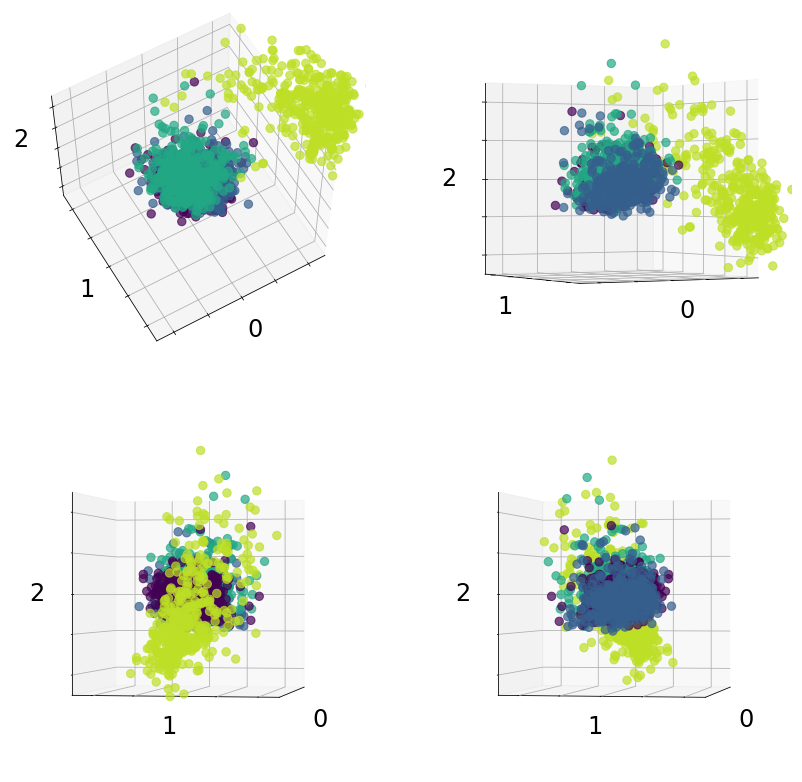

In [18]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/mw3_3feats.png')

## Neural Network

In [19]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [20]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.38517282
Validation score: 0.885998
Iteration 2, loss = 0.23639567
Validation score: 0.940821
Iteration 3, loss = 0.13917782
Validation score: 0.963808
Iteration 4, loss = 0.08956925
Validation score: 0.987694
Iteration 5, loss = 0.06430331
Validation score: 0.990229
Iteration 6, loss = 0.05026140
Validation score: 0.995336
Iteration 7, loss = 0.04341524
Validation score: 0.995902
Iteration 8, loss = 0.03948712
Validation score: 0.997600
Iteration 9, loss = 0.03678603
Validation score: 0.998117
Iteration 10, loss = 0.03553571
Validation score: 0.996074
Iteration 11, loss = 0.03428796
Validation score: 0.996825
Iteration 12, loss = 0.03402803
Validation score: 0.996899
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 13, loss = 0.02356066
Validation score: 0.999249
Iteration 14, loss = 0.02280584
Validation score: 0.999200
Iteration 15, loss = 0.02260390
Validation score: 0.999335
Iterat